## 3. Data Cleaning, Feature Engineering
***

In this file, we will be taking our post/comment data through the cleaning process, in addition to some light feature engineering. We'll start by dealing with NaNs, drop posts that we don't think are valuable to keep, and clean the text for our posts and comments.

From there, we'll also incorporate some new features into our dataset including a **profanity flag and a pun flag**. Finally, through iterative model testing, we will also **drop words that are not adding value to our final model build**.

**Executive Summary**:
 - [Before We Clean...](#Before-we-clean...)
 - [Cleaning](#Cleaning)
 - [Looking Into Joke Length](#Joke-Length-Deep-Dive)
 - [Additional Features](#Additional-Features)

### Load Data/Libraries

In [552]:
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import time
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer#### NaN Check
from scipy import stats

In [553]:
#Read in our post and comment data
jokes_df = pd.read_csv('./datasets/jokedata.csv')

In [554]:
#Change self-text column name to be 'body'
jokes_df = jokes_df.rename(columns={'selftext':'body'})

In [555]:
#lowercase our test
jokes_df['body'] = jokes_df['body'].str.lower()
jokes_df['title'] = jokes_df['title'].str.lower()

### Before we clean...

Before going further with model cleaning, we'll do a quick check to see if question marks in our post titles are more characteristic of a r/DadJoke post than an r/Joke post. Often times dad jokes rely on punch lines, so lets take a look

*Question Marks*

In [556]:
#jokes_df.loc[jokes_df['title'].str.contains('?'), 'subreddit'].value_counts()[0];
#jokes_df.loc[jokes_df['title'].str.contains('?'), 'subreddit'].value_counts()[1];

It appears that this is not a common feature for us to evaluate when classifying our jokes either. No titles contain a question mark. Given that titles are typically the setup, we can infer that question marks are not going to be valuable information for us and we can proceed with cleaning.

"*What do, Why do..." Joke Setup*

In [557]:
joke_construct_list = ['why do', 'how do', 'what do', 'did you']

In [558]:
#Proportion of Dad jokes that start with 'what do'
print(jokes_df.loc[jokes_df['title'].str.contains('|'.join(joke_construct_list)), 'subreddit'].value_counts()[0])
((jokes_df.loc[jokes_df['title'].str.contains('|'.join(joke_construct_list)), 'subreddit'].value_counts()[0]) / len(jokes_df[jokes_df['subreddit'] == 'dadjokes']) * 100).round(2)

489


16.29

In [559]:
#Proportion of regular jokes that start with 'what do'
print(jokes_df.loc[jokes_df['title'].str.contains('|'.join(joke_construct_list)), 'subreddit'].value_counts()[1])
((jokes_df.loc[jokes_df['title'].str.contains('|'.join(joke_construct_list)), 'subreddit'].value_counts()[1]) / len(jokes_df[jokes_df['subreddit'] == 'Jokes']) * 100).round(2)

363


12.1

Upon further investigation, this does appear to be a stronger characteristic of the r/DadJoke post. This is something that we'll revisit when it comes time to introduce new features.

***
## Cleaning

In [560]:
#Convert our target into binary numerical representation
jokes_df['subreddit']= jokes_df['subreddit'].map({'dadjokes':1, 'Jokes':0})

We detect a number of NaN values in the **comment** and **body** columns which suggest there's no text here. We'll fill with empty string so we can continue to deal with these rows.

#### NaN Check

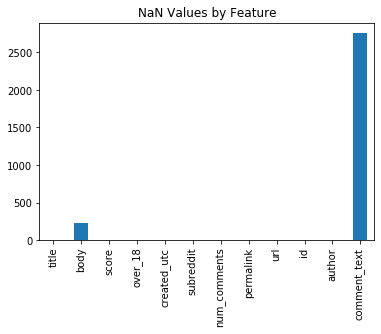

In [561]:
#Check our dataset for nulls
jokes_df.isnull().sum().plot(kind='bar');
plt.title('NaN Values by Feature');

In [562]:
#Fill Nans with empty string
jokes_df = jokes_df.fillna('')

#### Post Elimination

Knowing the nature of Reddit, we likely want to prune our posts and keep only the most relevant ones. Through iterative model testing and post exploration, we determine that posts should be eliminated if they meet any of the following criteria:

  - The title is empty
  - The title contains '/r' as this is likely an acknowledgement of the subreddit or a moderator post
  - The score is less than 8
  - The body of the submission contains 'edit, 'gif', or 'imgur.' Typically, 'edit' flag as post that has text that is not relevant to a joke. Often this will be acknowledgements of the post score, for example.

In [563]:
def joke_elimination(df):
    
    #Make copy of df for manipulation in function
    dfclean = df.copy()
    
    #dfclean = dfclean.rename(columns={'selftext':'body'})
    
    #Build list of posts with r/ in title, and drop them
    r_drop = list(dfclean.loc[df['title'].str.contains('r/'),:].index)
    dfclean = dfclean.drop(r_drop)

    #Check for title length, score, and features of body that we don't want to keep
    dfclean = dfclean[dfclean['title'].str.split().apply(len) != 0]
    #dfclean = dfclean[dfclean['title'].str.split().apply(len) >= 2]
    dfclean = dfclean[dfclean['score'] >=8]
    #dfclean = dfclean[dfclean['over_18'] == False]
    dfclean = dfclean[~dfclean['body'].str.contains("edit")]
    dfclean = dfclean[~dfclean['body'].str.contains(".gif")]
    dfclean = dfclean[~dfclean['body'].str.contains("imgur")]
    
    #Return a cleaned dataset
    return(dfclean)

In [564]:
#Execute joke elimination
jokes_df = joke_elimination(jokes_df)

We'll now move into the text cleaning phase for both our posts and our comments. We'll leverage a number of **regex** queries here to accomplish this. We're looking to eliminate any special characters, punctuation, and odd spacing prior to running our data through CountVectorizer/Tfidf later in the *Model Selection* notebook. Close inspection of both our posts and comments reveal slightly different processing steps, so we'll be cleaning these separately.

#### Post Cleaning

In [565]:
#In this order, execute a number of regex replace calls on 'title' abd 'body' to correct our post text data.
#Start by removing \r and \n's, then remove question marks. From there, check for odd characters and white space.
jokes_df[['title','body']] = jokes_df[['title','body']].replace(to_replace ='([\r\n]+)', value = ' ', regex = True) 
jokes_df[['title','body']] = jokes_df[['title','body']].replace(to_replace ='?', value = ' ', regex = False) 
jokes_df[['title','body']] = jokes_df[['title','body']].replace(to_replace ='[^\w\s]', value = '', regex = True) #### Post Cleaning
jokes_df[['title','body']] = jokes_df[['title','body']].replace(to_replace ='([ ]{2,})', value = ' ', regex = True) 

#### Comment Cleaning

In [566]:
#In this order, execute a number of regex replace calls on 'title' abd 'body' to correct our post text data.
#Start by removing our pipeline delimiter, then correct our spacing. Remove any non-letter characters and re-correct spacing
jokes_df['comment_text'] = jokes_df['comment_text'].replace(to_replace ='\|', value = ' ', regex = True) 
jokes_df['comment_text'] = jokes_df['comment_text'].replace(to_replace ='', value = ' ', regex = True) 
jokes_df['comment_text'] = jokes_df['comment_text'].replace(to_replace ='([\r\n]+)', value = ' ', regex = True) 
jokes_df['comment_text'] = jokes_df['comment_text'].replace(to_replace ='[^\w\s]', value = '', regex = True) 
jokes_df['comment_text'] = jokes_df['comment_text'].replace(to_replace ='([ ]{2,})', value = ' ', regex = True) 

Before moving into feature creation, there are a few minor things we need to do to clean up our dataframe. Ater inspecting the posts, the title and body of the post are often not duplicative, so I am comfortable **combining them** into a single, new column. I will also generate a **joke_length** column based on a count of words in this new column. Finally, I want to drop any posts that have an extremely long, or extremely short length. Posts less than 4 words long indicate poor quality posts; Posts longer than 3000 are indicative of lists in the body of the post.

#### Combine Title and Joke

In [567]:
#Bring together title and body into a singular column
jokes_df['joke'] = jokes_df['title'].str.cat(jokes_df['body'],sep=" ")

#### Duplicates

Pause here after dropping posts to check for duplicates and reassess sample. We've removed quite a few posts at this point, we're now down to ~2K total.

In [568]:
#Drop duplicate jokes from our dataframe by checking 'id' column. Check total sample by subreddit
jokes_df = jokes_df.drop_duplicates('id')
jokes_df = jokes_df.drop_duplicates('joke')

jokes_df['subreddit'].value_counts()

1    1121
0     815
Name: subreddit, dtype: int64

## Joke Length Deep Dive

#### Word Count

In [569]:
# Split out words and generate a new feature counting # of words
jokes_df['joke_length'] = jokes_df['joke'].str.split().apply(len)

In [570]:
#Check how this varies across subreddits
jokes_df.groupby('subreddit')['joke_length'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
0,815.0,51.182822,79.204970,4.0,14.0,19.0,38.0,875.0
1,1121.0,19.193577,23.963309,2.0,11.0,15.0,20.0,429.0


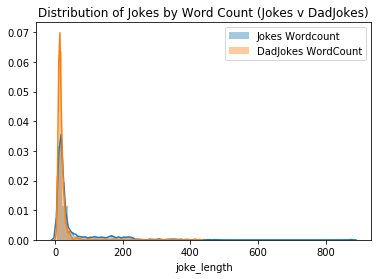

In [571]:
#Generate a plot of word count for our jokes by subreddit and plot distribution
fig = sns.distplot(jokes_df.loc[jokes_df['subreddit'] == 0,'joke_length']);
fig = sns.distplot(jokes_df.loc[jokes_df['subreddit'] == 1,'joke_length']);
plt.title("Distribution of Jokes by Word Count (Jokes v DadJokes)");
fig.legend(labels=['Jokes Wordcount','DadJokes WordCount']);

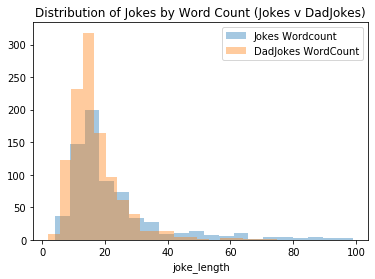

In [572]:
#Generate a plot of word count for our jokes by subreddit  with word count ess than 50. Plot distribution
fig = sns.distplot(jokes_df.loc[(jokes_df['subreddit'] == 0) & (jokes_df['joke_length'] < 100),'joke_length'], kde=False, bins=20);
fig = sns.distplot(jokes_df.loc[(jokes_df['subreddit'] == 1)& (jokes_df['joke_length'] < 100),'joke_length'], kde=False, bins=20);
plt.title("Distribution of Jokes by Word Count (Jokes v DadJokes)");
fig.legend(labels=['Jokes Wordcount','DadJokes WordCount']);

Clearly there is a sizeable difference in joke length between subreddits. When we isolate down to observations with less than 100 words, you can see a higher frequency of dad jokes under 20 words long. This is intuitive -- more complicated jokes take longer to tell. Let's see if we can see any relationship between joke length and score by subreddit.

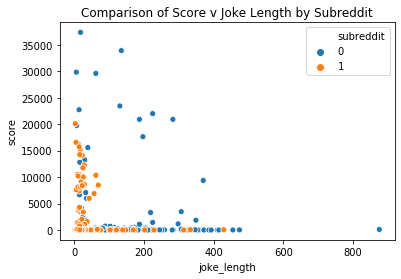

In [573]:
#Scatterplot comparing score to joke length by subreddit
sns.scatterplot(data=jokes_df, x='joke_length', y='score', hue='subreddit');
plt.title('Comparison of Score v Joke Length by Subreddit');

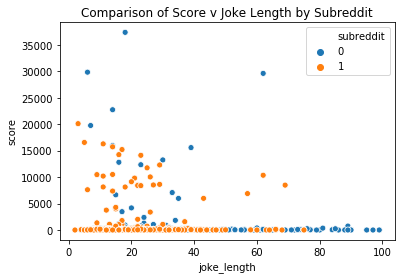

In [574]:
#Scatterplot comparing score to joke length by subredditb
sns.scatterplot(data=jokes_df[jokes_df['joke_length'] < 100], x='joke_length', y='score', hue='subreddit');
plt.title('Comparison of Score v Joke Length by Subreddit');

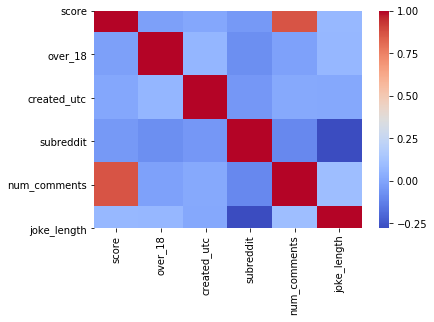

In [575]:
sns.heatmap(jokes_df.corr(), cmap="coolwarm");

From the above scatterplots, we notice that there is a greater concentration of r/DadJokes that score higher with fewer words. Looking at our dataset more generally, we notice a weak negative correlation between joke length and our subreddit target. Based on what we see here, we'll move forward with including this feature when we build our alternative model.

***
## Additional Features

#### Elminate Outliers

In [576]:
#Drop jokes with less than 4 words, or more than 800 words
jokes_df = jokes_df.loc[(jokes_df['joke_length'] < 800) & (jokes_df['joke_length'] > 5)]

#### Combine Title, Joke, Comment into New Feature

In [577]:
#Bring together title and body into a singular column
jokes_df['full_text'] = jokes_df['joke'] + ' ' + jokes_df['comment_text']

For our next step, we'll be **feature engineering.** These features won't be part of our NLP-based-model, but we want to see if a separate model based on a simpler, more traditional data set can outperform the former. Dad jokes often rely on puns. As described in our separate notebook, we want to read in a list of homonyms and homophones to nuild a **pun flag** that we believe can help differentiate a dad joke. 

Second, dad jokes are clean in nature. Reddit's JSON data include an *over_18* flag that is helpful for understanding this, but we can also simply flag **profanity** as well. The profanity here was included after assessing the coefficients of our model-- these were among some of the words that were most indicative of a non-dad joke. 

Finally, as part of final check here, we'll revisit our original idea around **setup flagging**. We'll encode jokes by their setup and create dummies to feed into our non-NLP based model.

We'll then be ready to read to a csv and move into model preparation/selection.

### Add in Pun Flag/Count

In [578]:
#Read in pun data set
puns_df = pd.read_csv('./datasets/puns.csv')

#Save puns to a list
pun_list = list(puns_df['0'])

#Read through our text and find any row that contains a "pun word".
pun_candidate_ids = list(jokes_df.loc[jokes_df['joke'].str.contains('|'.join(pun_list)),'id'])

#Initialize a 'pun' feature column and set to zero for now
jokes_df['pun'] = 0

#Where we find a'pun word', change the value to 1 / set pun flag to 1
jokes_df.loc[jokes_df['joke'].str.contains('|'.join(pun_list)),'pun'] = 1

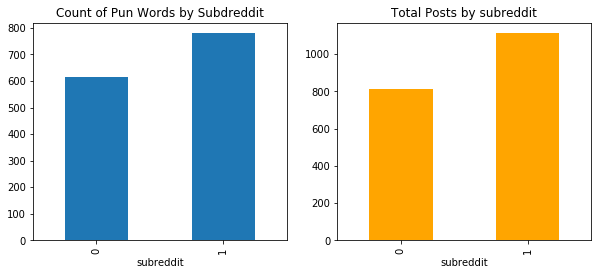

In [579]:
#Check how this varies across subreddits
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
jokes_df.groupby('subreddit')['pun'].sum().plot(kind='bar');
plt.title('Count of Pun Words by Subdreddit');
plt.subplot(1,2,2)
jokes_df.groupby('subreddit')['pun'].count().plot(kind='bar', color='orange');
plt.title('Total Posts by subreddit');

In [580]:
#Porportion of jokes getting pun flag by subreddit
jokes_df.groupby('subreddit')['pun'].sum() /  jokes_df.groupby('subreddit')['pun'].count()

subreddit
0    0.756158
1    0.700540
Name: pun, dtype: float64

While we are picking up more dadjokes, the proportion of dadjokes being flagged for these words are lower. This is unlikely to be an effective feature for us that may drop out of our model during regularization.

### Profanity Flag

In [581]:
#Bring in profane words that were strong subreddit differentiators from our model output
#WILL DONT LOOK AT THIS 
profanity = ['fuck', 'shit', 'bitch', 'asshole', 'ass', '911', 'black', 'fucking', 'jesus', 'gay']

#Build list of ids with profanity in the text so we can reference
profanity_candidate_ids = list(jokes_df.loc[jokes_df['joke'].str.contains('|'.join(profanity)),'id'])

#Initialize a profanity flag with value set to zero
jokes_df['profanity'] = 0

#Set out new feature to 1 if profanity is there
jokes_df.loc[jokes_df['joke'].str.contains('|'.join(profanity)),'profanity'] = 1

#Just for good measure, in case users/mods aren't setting 'over_18' to True on jokes with profanity, let's include these
jokes_df.loc[jokes_df['over_18'] == True, 'profanity'] = 1

### Setup Flag

In [582]:
#build our list of potential setups
joke_construct_list

['why do', 'how do', 'what do', 'did you']

In [583]:
#Start with an empty new feature
jokes_df['setup']= ''

In [584]:
#Find occurences of each setup, and flag the setup within our new feature
for i in range(len(joke_construct_list)):
    jokes_df.loc[jokes_df['title'].str.contains(joke_construct_list[i]),'setup'] = joke_construct_list[i]

In [585]:
#Convert to dummy features
jokes_df = pd.get_dummies(jokes_df, columns=['setup'], drop_first=True)

### Read to CSV

In [586]:
# Read our file out to CSV
jokes_df.to_csv('./datasets/jokesclean.csv', index=False)